In [1]:
import pandas as pd
import os
import xarray as xr
from tqdm import tqdm

In [2]:
# download dir
avp_download_dir = "/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/"
kps_download_dir = "/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/"

ftp_url = 'ftp1.esrl.noaa.gov'
# Avery Picnic product
avp_url = f'Observations/Campaigns/SPLASH/asfs50/2_level_ingest/'
# Kettle Ponds product
kps_url = f'Observations/Campaigns/SPLASH/asfs30/2_level_ingest/'

In [3]:

# Get the list of files in the directory
file_list = os.listdir(kps_download_dir)

file_list = [f for f in file_list if 'sledmet.asfs30.level2.0.1min.' in f]

# Sort the file list
file_list.sort()

In [4]:
ds = xr.open_dataset(os.path.join(kps_download_dir, file_list[0]))
ds['h2o_licor'].plot

In [5]:
# Create an empty list to store the dataarrays
mixingratio_dataarray_list = []

abshum_dataarray_list = []

# Iterate over each file with tqdm
for file_name in tqdm(file_list):
    # Open the file using xarray
    dataset = xr.open_dataset(os.path.join(kps_download_dir, file_name))
    
    # Extract the dataarray for the variable 'mixing_ratio', Add the dataarray to the list
    mixingratio_dataarray_list.append(dataset['mixing_ratio'])
    abshum_dataarray_list.append(dataset['h2o_licor'])

100%|██████████| 646/646 [00:48<00:00, 13.30it/s]


In [6]:
from sublimpy import utils

In [7]:
mixingratio_ds = xr.concat(mixingratio_dataarray_list, dim='time')
mixingratio_ds = utils.modify_xarray_timezone(mixingratio_ds, 'UTC', 'US/Mountain')
abshum_ds = xr.concat(abshum_dataarray_list, dim='time')
abshum_ds = utils.modify_xarray_timezone(abshum_ds, 'UTC', 'US/Mountain')

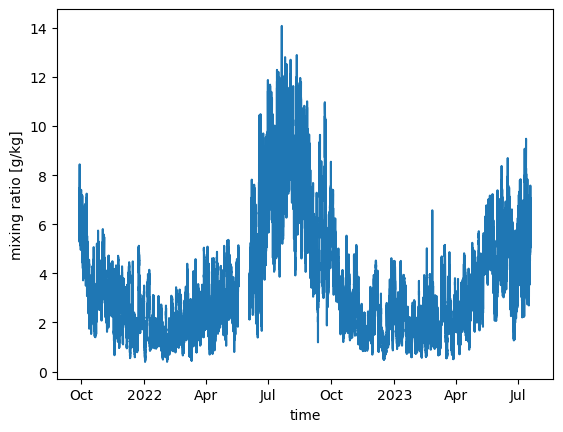

In [8]:
mixingratio_ds.plot()

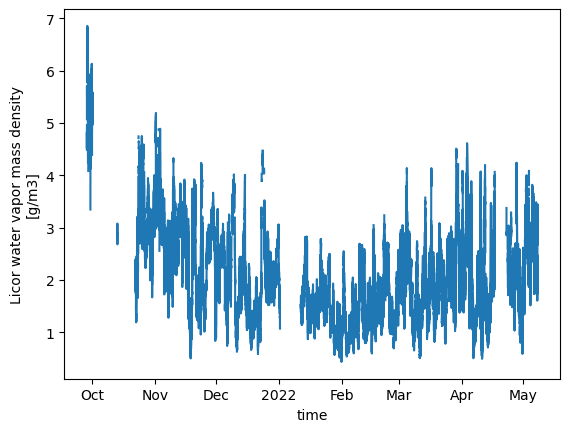

In [9]:
abshum_ds.plot()

In [10]:
heights = [1,3,10]
HORIZ_GRID_SPACING = 50
VERT_GRID_SPACING = 20
start_date = '20221130'
end_date = '20230509'
    # streamwise-coords
# tidy_df = pd.read_parquet(f"tidy_df_{start_date}_{end_date}_planar_fit_multiplane.parquet")
    # slope-adjusted earthwise-coords
tidy_df = pd.read_parquet(f"tidy_df_{start_date}_{end_date}_planar_fit.parquet")
    # sonic coords
# tidy_df = pd.read_parquet(f"tidy_df_{start_date}_{end_date}_noplanar_fit.parquet")

tidy_df = utils.modify_df_timezone(tidy_df, 'UTC', 'US/Mountain')

In [11]:
# this is created in the flux_divergence_3d_numerical_pawu.ipynb notebook
src = pd.read_csv('irga_mixingratio_estimates.csv')
src.time = pd.to_datetime(src.time)
from sublimpy import utils
src.value = src.value*1000
src = src.set_index('time')

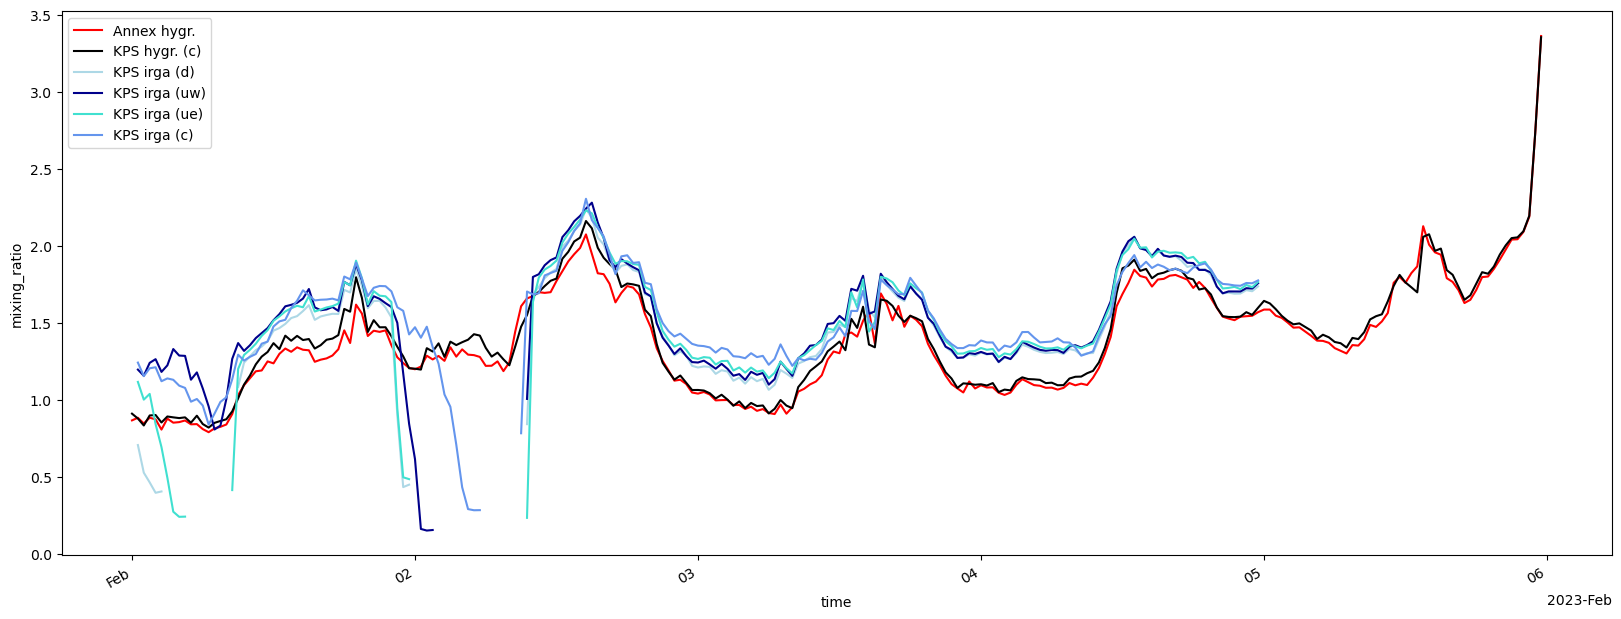

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,8))
mixingratio_ds.to_dataframe().sort_index().to_xarray().sel(time=slice('20230201', '20230205')).resample(time='30min').mean()['mixing_ratio'].plot(ax=ax, label='Annex hygr.', color='red')
(tidy_df.query("variable == 'mixingratio_3m_c'").set_index('time').loc['20230201': '20230205']['value']*1000).plot(ax=ax, label='KPS hygr. (c)', color='black')
src.query("tower == 'd'")['value'].plot(ax=ax, label='KPS irga (d)', color='lightblue')
src.query("tower == 'uw'")['value'].plot(ax=ax, label='KPS irga (uw)', color='darkblue')
src.query("tower == 'ue'")['value'].plot(ax=ax, label='KPS irga (ue)', color='turquoise')
src.query("tower == 'c'")['value'].plot(ax=ax, label='KPS irga (c)', color='cornflowerblue')
plt.legend()

Text(0, 0.5, 'mixing ration [g/kg]')

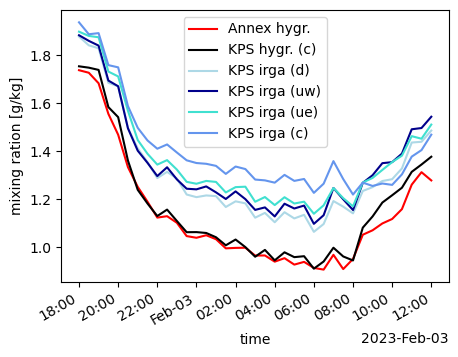

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,4))
mixingratio_ds.to_dataframe().sort_index().to_xarray().sel(time=slice('20230202 1800','20230203 1200')).resample(time='30min').mean()['mixing_ratio'].plot(ax=ax, label='Annex hygr.', color='red')
(tidy_df.query("variable == 'mixingratio_3m_c'").set_index('time').loc['20230202 1800':'20230203 1200']['value']*1000).plot(ax=ax, label='KPS hygr. (c)', color='black')
src.sort_index().loc['20230202 1800':'20230203 1200'].query("tower == 'd'")['value'].plot(ax=ax, label='KPS irga (d)', color='lightblue')
src.sort_index().loc['20230202 1800':'20230203 1200'].query("tower == 'uw'")['value'].plot(ax=ax, label='KPS irga (uw)', color='darkblue')
src.sort_index().loc['20230202 1800':'20230203 1200'].query("tower == 'ue'")['value'].plot(ax=ax, label='KPS irga (ue)', color='turquoise')
src.sort_index().loc['20230202 1800':'20230203 1200'].query("tower == 'c'")['value'].plot(ax=ax, label='KPS irga (c)', color='cornflowerblue')
plt.legend()
plt.ylabel('mixing ration [g/kg]')

# Scaling analysis (for 1D advection)

## Horizontal advection using KPS and Annex hygrometer measurements

In [14]:
kpsannex_mixingratio_measurements = mixingratio_ds.sortby('time').sel(
    time=slice('20221101', '20230620')
).resample(time='30min').mean().rename('annex').to_dataframe() / 1000
kps_mixingratio_measurements = tidy_df.query("variable == 'mixingratio_3m_c'").set_index('time').loc[
    '20221101': '20230620'
]['value'].rename('kps')
kpsannex_mixingratio_measurements.join(kps_mixingratio_measurements).dropna()

,annex,kps
time,,
2022-11-29 17:00:00,0.001305,0.001318
2022-11-29 17:30:00,0.001009,0.000998
2022-11-29 18:00:00,0.000942,0.000963
2022-11-29 18:30:00,0.001089,0.001029
2022-11-29 19:00:00,0.001065,0.001066
...,...,...
2023-05-09 15:30:00,0.002747,0.002823
2023-05-09 16:00:00,0.002813,0.002866
2023-05-09 16:30:00,0.002903,0.003071


In [15]:
kpsannex_mixingratio_measurements = mixingratio_ds.sortby('time').sel(
    time=slice('20221101', '20230620')
).resample(time='30min').mean().rename('annex').to_dataframe() / 1000
kps_mixingratio_measurements = tidy_df.query("variable == 'mixingratio_3m_c'").set_index('time').loc[
    '20221101': '20230620'
]['value'].rename('kps')
kps_vs_annex_df = kpsannex_mixingratio_measurements.join(kps_mixingratio_measurements)
kps_vs_annex_df
kps_vs_annex_df['ds'] = kps_vs_annex_df['annex'] - kps_vs_annex_df['kps']
kps_vs_annex_df['dx'] = 400
kps_vs_annex_df['ds/dx'] = kps_vs_annex_df['ds'] / kps_vs_annex_df['dx']
kps_vs_annex_df['u'] = tidy_df.query("variable == 'u_3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('u')
kps_vs_annex_df['rho'] = 1000*tidy_df.query("variable == 'dryairdensity_3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('rho')
kps_vs_annex_df['w_h2o__3m_c'] = tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('rho')
kps_vs_annex_df.dropna()

,annex,kps,ds,dx,ds/dx,u,rho,w_h2o__3m_c
time,,,,,,,,
2022-11-29 17:00:00,0.001305,0.001318,-0.000013,400,-3.159350e-08,1.527606,955.117583,0.001880
2022-11-29 17:30:00,0.001009,0.000998,0.000011,400,2.698302e-08,2.558416,956.407905,0.000423
2022-11-29 18:00:00,0.000942,0.000963,-0.000021,400,-5.227869e-08,2.566608,958.413422,-0.000601
2022-11-29 18:30:00,0.001089,0.001029,0.000060,400,1.510731e-07,-0.962255,965.276897,-0.001731
2022-11-29 19:00:00,0.001065,0.001066,-0.000002,400,-4.770127e-09,-0.768659,970.971227,-0.000575
...,...,...,...,...,...,...,...,...
2023-05-09 15:30:00,0.002747,0.002823,-0.000076,400,-1.893603e-07,0.870849,882.481873,0.012282
2023-05-09 16:00:00,0.002813,0.002866,-0.000053,400,-1.323862e-07,1.080842,881.548762,0.016927
2023-05-09 16:30:00,0.002903,0.003071,-0.000169,400,-4.215329e-07,1.178160,882.708192,0.009684


$$\large \overline{u} \space \overline{\rho} \frac{\partial s}{\partial x}$$

In [16]:
kps_vs_annex_df['lateral_advection'] = kps_vs_annex_df['u'] * kps_vs_annex_df['rho'] * kps_vs_annex_df['ds/dx']

In [17]:
kps_vs_annex_df['u'].mean(), kps_vs_annex_df['rho'].mean(), kps_vs_annex_df['ds/dx'].mean(), kps_vs_annex_df['lateral_advection'].mean()

(0.5693599417308806,
 937.3996369845211,
 -8.236571117967184e-08,
 -2.3154138610259073e-05)

In [18]:
kps_vs_annex_df = kps_vs_annex_df.sort_index()

In [19]:
import altair as alt
src = kps_vs_annex_df.copy()
src = (src.assign(lateral_advection= 7*src.lateral_advection)).reset_index()
src = src.set_index('time').sort_index().loc['20230201':'20230206']
alt.Chart(
    src.reset_index()
).transform_fold(
    ['lateral_advection', 'w_h2o__3m_c']
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').title('Water vapor flux density (g/m^2/s)'),
    alt.Color('key:N')
).properties(width = 800).configure_legend(orient='top', labelFontSize=16)

alt.Chart(...)

In [20]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [21]:
import altair as alt
# CONVERT TIMEZONE NOW THAT YOU HAVE JOINED THE DATA
src = kps_vs_annex_df.copy()
src = (src.assign(lateral_advection= 7*src.lateral_advection)).reset_index()
alt.Chart(
    src
).transform_fold(
    ['lateral_advection', 'w_h2o__3m_c']
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Water vapor flux density (g/m^2/s)').scale(
        domain=[-0.001, 0.006]
    ),
    alt.Color('key:N'),
).properties(width = 200, height = 200).display(renderer='svg')

alt.Chart(...)

In [22]:
import altair as alt
# CONVERT TIMEZONE NOW THAT YOU HAVE JOINED THE DATA
src = kps_vs_annex_df.copy()
src = (src.assign(lateral_advection= 7*src.lateral_advection)).reset_index()
alt.Chart(
    src
).transform_fold(
    ['lateral_advection', 'w_h2o__3m_c']
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N'),
    alt.Facet('month(time):T').sort(['Nov','Dec','Jan','Feb','Mar','Apr','May','Jun'])
).properties(width = 200, height = 200)

alt.Chart(...)

Assume a 1D equation for advective divergence.

$\overline{u} \space \overline{\rho} \frac{\partial s}{\partial x}$

For the night of Feb 2nd approximately:
* a 0.2 difference in the mixing ratio ($s$) between the two sites ($\Delta s \approx 0.2$ g/kg $\approx 0.0002$ g/g)
* The sites are about 500 meters apart ($\Delta x \approx  500$ meters)
* Wind speed could be 1-2 meters ($\overline{u} \approx 1$)
* Density could be about 960 g/m $^3$

So our advective term might equal:

$1 (m/s) * 960 g/m^3 * 0.0002 / 500 m$

This results in about $0.0003$ g/m^3/s, or, multiplying by the height of our site to get a flux density, 7m, 0.002-0.003 g/m^2/s

## Vertical advection using KPS hygrometer measurements

In [23]:
kps_mixingratio_measurements_3m = tidy_df.query("variable == 'mixingratio_3m_c'").set_index('time').loc[
    '20221101': '20230620'
]['value'].rename('mixingratio_3m_c')
kps_mixingratio_measurements_10m = tidy_df.query("variable == 'mixingratio_10m_c'").set_index('time').loc[
    '20221101': '20230620'
]['value'].rename('mixingratio_10m_c')
kps_vert_df = pd.DataFrame(kps_mixingratio_measurements_3m).join(kps_mixingratio_measurements_10m)
kps_vert_df['ds'] = kps_vert_df['mixingratio_10m_c'] - kps_vert_df['mixingratio_3m_c']
kps_vert_df['dz'] = 7
kps_vert_df['ds/dz'] = kps_vert_df['ds'] / kps_vert_df['dz']
kps_vert_df['w'] = tidy_df.query("variable == 'w_5m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w')
kps_vert_df['rho'] = 1000*tidy_df.query("variable == 'dryairdensity_5m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('rho')
kps_vert_df['w_h2o__3m_c'] = tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('rho')
kps_vert_df['vertical_advection'] =  kps_vert_df['w'] * kps_vert_df['rho'] * kps_vert_df['ds/dz']
kps_vert_df

,mixingratio_3m_c,mixingratio_10m_c,ds,dz,ds/dz,w,rho,w_h2o__3m_c,vertical_advection
time,,,,,,,,,
2022-11-29 17:00:00,0.001318,0.001302,-0.000016,7,-2.251871e-06,-0.035817,954.409480,0.001880,0.000077
2022-11-29 17:30:00,0.000998,0.000983,-0.000015,7,-2.122368e-06,-0.006491,955.233276,0.000423,0.000013
2022-11-29 18:00:00,0.000963,0.000964,0.000001,7,1.819073e-07,-0.010225,957.203269,-0.000601,-0.000002
2022-11-29 18:30:00,0.001029,0.001033,0.000005,7,7.098507e-07,-0.091964,964.337707,-0.001731,-0.000063
2022-11-29 19:00:00,0.001066,0.001073,0.000007,7,9.447935e-07,-0.040337,969.506621,-0.000575,-0.000037
...,...,...,...,...,...,...,...,...,...
2023-05-09 15:30:00,0.002823,0.002581,-0.000241,7,-3.448501e-05,-0.055008,881.058455,0.012282,0.001671
2023-05-09 16:00:00,0.002866,0.002647,-0.000219,7,-3.125974e-05,-0.044537,880.172372,0.016927,0.001225
2023-05-09 16:30:00,0.003071,0.002800,-0.000271,7,-3.876823e-05,-0.053648,881.145358,0.009684,0.001833


In [24]:
import altair as alt
# CONVERT TIMEZONE NOW THAT YOU HAVE JOINED THE DATA
src = kps_vert_df.copy()
src = (src.assign(vertical_advection= 7*src.vertical_advection)).reset_index()
alt.Chart(
    src
).transform_fold(
    ['vertical_advection', 'w_h2o__3m_c']
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Water vapor flux density (g/m^2/s)').scale(
        domain=[-0.001, 0.006]
    ),
    alt.Color('key:N'),
).properties(width = 200, height = 200).display(renderer='svg')

alt.Chart(...)

In [25]:
import altair as alt
# CONVERT TIMEZONE NOW THAT YOU HAVE JOINED THE DATA
src = kps_vert_df.copy()
src = (src.assign(vertical_advection= 7*src.vertical_advection)).reset_index()
alt.Chart(
    src
).transform_fold(
    ['vertical_advection', 'w_h2o__3m_c']
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N'),
    alt.Facet('month(time):T').sort(['Nov','Dec','Jan','Feb','Mar','Apr','May','Jun'])
).properties(width = 200, height = 200)

alt.Chart(...)

In [26]:
alt.Chart(
    tidy_df[tidy_df.variable.isin(['w_2m_c', 'w_3m_c', 'w_5m_c', 'w_10m_c', 'w_15m_c', 'w_20m_c',])]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Water vapor flux density (g/m^2/s)'),
    alt.Color('height:O'),
    tooltip='height',
).properties(width = 200, height = 200) | alt.Chart(
    tidy_df[tidy_df.variable.isin(['mixingratio_2m_c', 'mixingratio_3m_c', 'mixingratio_5m_c', 'mixingratio_10m_c', 'mixingratio_15m_c', 'mixingratio_20m_c',])]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Water vapor mixing ratio (g/g)').scale(zero=False),
    alt.Color('height:O'),
    tooltip='height',
).properties(width = 200, height = 200)

alt.HConcatChart(...)

## Horizontal advection using KPS gas analyzer measurements

In [27]:
import pandas as pd

In [28]:
mixing_ratio_field_df = pd.read_pickle('mixing_ratio_field_df.pkl')
mixing_ratio_field_df


height                   1.0                                     3.0   \
tower                       c         d        ue        uw         c   
measurement                 r         r         r         r         r   
time                                                                    
2022-11-30 00:00:00  0.000639  0.001155  0.000811  0.000662  0.001211   
2022-11-30 00:30:00  0.000742  0.001256  0.000808  0.000679  0.001329   
2022-11-30 01:00:00  0.000774  0.001259  0.000808  0.000667  0.001347   
2022-11-30 01:30:00  0.000730  0.001210  0.000806  0.000633  0.001316   
2022-11-30 02:00:00  0.000728  0.001254  0.000808  0.000627  0.001351   
...                       ...       ...       ...       ...       ...   
2023-05-08 21:30:00  0.002870       NaN       NaN       NaN  0.002893   
2023-05-08 22:00:00  0.003138       NaN       NaN       NaN  0.003100   
2023-05-08 22:30:00  0.003273       NaN       NaN       NaN  0.003357   
2023-05-08 23:00:00  0.003331       NaN       NaN       NaN  0.003334   
2023-05-08 23:30:00  0.003289       NaN       NaN       NaN  0.003301   

height                                                 10.0            \
tower                       d        ue        uw         c         d   
measurement                 r         r         r         r         r   
time                                                                    
2022-11-30 00:00:00  0.000762  0.000797  0.000878  0.001026  0.000928   
2022-11-30 00:30:00  0.000797  0.000769  0.000951  0.001067  0.000990   
2022-11-30 01:00:00  0.000797  0.000797  0.000979  0.001097  0.001021   
2022-11-30 01:30:00  0.000805  0.000814  0.000937  0.001077  0.000997   
2022-11-30 02:00:00  0.000707  0.000715  0.000959  0.001116  0.001021   
...                       ...       ...       ...       ...       ...   
2023-05-08 21:30:00  0.003100  0.003087  0.003163  0.002859  0.002906   
2023-05-08 22:00:00  0.003268  0.003233  0.003371  0.002993  0.003006   
2023-05-08 22:30:00  0.003492  0.003478  0.003582  0.003359  0.003267   
2023-05-08 23:00:00  0.003511  0.003471  0.003590  0.003346  0.003261   
2023-05-08 23:30:00  0.003466  0.003453  0.003563  0.003230  0.003154   

height                                   
tower                      ue        uw  
measurement                 r         r  
time                                     
2022-11-30 00:00:00  0.001021  0.001024  
2022-11-30 00:30:00  0.001098  0.001145  
2022-11-30 01:00:00  0.001141  0.001182  
2022-11-30 01:30:00  0.001107  0.001160  
2022-11-30 02:00:00  0.001138  0.001201  
...                       ...       ...  
2023-05-08 21:30:00  0.002893  0.002629  
2023-05-08 22:00:00  0.003101  0.002740  
2023-05-08 22:30:00  0.003348  0.003000  
2023-05-08 23:00:00  0.003277  0.002976  
2023-05-08 23:30:00  0.003179  0.002874  

[7664 rows x 12 columns]

In [29]:
upwind_s = 0.5*(mixing_ratio_field_df[3, 'ue', 'r'] + mixing_ratio_field_df[3, 'uw', 'r'])
upwind_s.name = 'upwind_s'
kps_df = pd.DataFrame(upwind_s)
kps_df['downwind_s'] = mixing_ratio_field_df[3, 'd', 'r']
kps_df['ds'] = kps_df['downwind_s'] - kps_df['upwind_s']
kps_df['dx'] = 32
kps_df['ds/dx'] = kps_df['ds'] / kps_df['dx']
kps_df = kps_df.join(
    tidy_df.query("variable == 'u_3m_c'").set_index('time')['value'].rename('u')
)
kps_df = kps_df.join(
    1000*tidy_df.query("variable == 'dryairdensity_3m_c'").set_index('time')['value'].rename('rho')
)
kps_df = kps_df.join(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time')['value'].rename('w_h2o__3m_c')
)
kps_df['lateral_advection'] = kps_df['u'] * kps_df['rho'] * kps_df['ds/dx']
kps_df

,upwind_s,downwind_s,ds,dx,ds/dx,u,rho,w_h2o__3m_c,lateral_advection
time,,,,,,,,,
2022-11-30 00:00:00,0.000838,0.000762,-0.000076,32,-2.375491e-06,1.475889,991.887331,-0.000315,-0.003478
2022-11-30 00:30:00,0.000860,0.000797,-0.000063,32,-1.979030e-06,-0.216163,987.669706,-0.000521,0.000423
2022-11-30 01:00:00,0.000888,0.000797,-0.000091,32,-2.839329e-06,0.514044,988.873661,-0.000430,-0.001443
2022-11-30 01:30:00,0.000876,0.000805,-0.000071,32,-2.204861e-06,1.202963,989.953995,-0.000097,-0.002626
2022-11-30 02:00:00,0.000837,0.000707,-0.000131,32,-4.082891e-06,-0.220935,988.516927,-0.001609,0.000892
...,...,...,...,...,...,...,...,...,...
2023-05-08 21:30:00,0.003125,0.003100,-0.000025,32,-7.963226e-07,0.735877,896.669090,0.014479,-0.000525
2023-05-08 22:00:00,0.003302,0.003268,-0.000034,32,-1.055014e-06,0.683521,897.454560,0.001136,-0.000647
2023-05-08 22:30:00,0.003530,0.003492,-0.000038,32,-1.188108e-06,-0.389636,904.827356,0.002252,0.000419


In [30]:

import altair as alt
# CONVERT TIMEZONE NOW THAT YOU HAVE JOINED THE DATA
src = kps_df.copy()
src = (src.assign(lateral_advection= 7*src.lateral_advection)).reset_index()
alt.Chart(
    src
).transform_fold(
    ['lateral_advection', 'w_h2o__3m_c']
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Water vapor flux density (g/m^2/s)'),
    alt.Color('key:N'),
).properties(width = 200, height = 200)

alt.Chart(...)

In [31]:
import numpy as np
np.nanmean(kps_vs_annex_df.ds)

-3.2946284471868736e-05

In [32]:
np.nanmean(kps_df.ds)

-1.5818303581917505e-05

In [33]:
print(len(kps_vs_annex_df.dropna()))
print(len(kps_vert_df.dropna()))
print(len(kps_df.dropna()))

7254
7503
6771


In [38]:
src = kps_vs_annex_df[['lateral_advection']].rename(
        columns={'lateral_advection': 'kps-annex lateral advection'}
    ).join(
        kps_vert_df[['vertical_advection']].rename(
            columns={'vertical_advection': 'kps vertical advection'}
        )
    ).join(
        kps_df[['lateral_advection', 'w_h2o__3m_c']].rename(
            columns={'lateral_advection': 'kps lateral advection'}
        )
    )

src['kps-annex lateral advection'] = 7 * src['kps-annex lateral advection']
src['kps vertical advection'] = 7 * src['kps vertical advection']
src['kps lateral advection'] = 7 * src['kps lateral advection']

In [45]:
(
    alt.Chart(
        src.reset_index()
    ).transform_fold([
        'kps vertical advection',
        'kps lateral advection',
        'w_h2o__3m_c',
    ]).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(value):Q'),
        alt.Color('key:N')
    ) | alt.Chart(
        src.reset_index()
    ).transform_fold([
        'kps-annex lateral advection',
        'w_h2o__3m_c',
    ]).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(value):Q'),
        alt.Color('key:N')
    )
).resolve_scale(y='shared')

alt.HConcatChart(...)